# Import Data

In [1]:
# helper.py
from helper import *

In [2]:
# load data
df = pd.read_csv('./data/clean/features.csv')

# check
df.shape, len(set(df.player))

((1034, 310), 227)

- Over 1000 QB seasons for training and validation.
- 306 features (excluding player name, team, year, and target).
- 227 unique QBs.

# Optimize XGBoost

In [4]:
# non-feature cols
non_feat_cols = ['player', 'team_name', 'year', 'target']

# define X and y
X = df.drop(columns=non_feat_cols)
y = df['target']

In [ ]:
# define the parameter search space
param_bounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.001, 0.1),
    'gamma': (0, 1),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# run bayesian optimization
optimizer = BayesianOptimization(f=lambda max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree: 
            xgb_cv(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, X, y),
            pbounds=param_bounds,
            random_state=SEED,
            verbose=2)

# optimize for 110 iterations
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -12.27    | 0.5052    | 0.5019    | 0.05008   | 2.204     | 2.279     | 0.6093    |
| 2         | -12.65    | 0.7093    | 0.2481    | 0.009322  | 4.109     | 2.501     | 0.9393    |
| 3         | -12.69    | 0.9755    | 0.03875   | 0.07021   | 6.155     | 9.082     | 0.8334    |
| 4         | -12.34    | 0.7739    | 0.7024    | 0.03926   | 7.25      | 8.424     | 0.7328    |
| 5         | -12.48    | 0.9703    | 0.8037    | 0.09835   | 2.527     | 5.69      | 0.9728    |
| 6         | -12.47    | 0.8248    | 0.8608    | 0.09711   | 2.67      | 3.188     | 0.9367    |
| 7         | -12.33    | 0.9531    | 0.7583    | 0.03534   | 5.172     | 6.495     | 0.7481    |
| 8         | -12.41    | 0.739     | 0.4356    | 0.08717   | 2.686     | 7.189     | 0.8518    |
| 9         | -12.68

In [6]:
# get best parameters
best_params = {'colsample_bytree': 0.5161271934865836,
 'gamma': 0.5634437647901608,
 'learning_rate': 0.05682328154733499,
 'max_depth': 2,
 'min_child_weight': 2,
 'subsample': 0.5733165825944126}

# define model
xgb = XGBRegressor(**best_params, n_estimators=100, random_state=SEED, n_jobs=-1)

# Predict on 2024
Here we will train on the 2006-2022 data and then use the 2023 data as the holdout test set to predict the 2024 grades.

In [7]:
# define training data (before 2023) and test data (2023)
X_train = df.query('year < 2023').drop(columns=non_feat_cols)
y_train = df.query('year < 2023')['target']
X_test = df.query('year == 2023').drop(columns=non_feat_cols)
y_test = df.query('year == 2023')['target']

# train model
xgb.fit(X_train, y_train)

# make predictions
y_pred = xgb.predict(X_test)

# evaluate model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'R2: {r2:.4f}')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

- The best model resulted with a RMSE of 12.39 and a r2 of 0.31 when predicting on the holdout set (2024).

In [ ]:
# create a df for our predictions
preds_df = pd.DataFrame(data={'player': df.query('year == 2023')['player'].values, 'team': df.query('year == 2023')['team_name'].values, 'y_true': y_test, 'y_pred': y_pred, 'error': (y_pred - y_test)})

# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(TEAM_COLORS)

# show predictions for all QBs
preds_df.sort_values('error')[['player', 'y_true', 'y_pred', 'error']].T

RMSE: 12.157436114762524
R^2 : 0.397691290884134


In [13]:
# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)

print(f'{percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

64.6% of our model's predictions are within 10 pts of the true value.


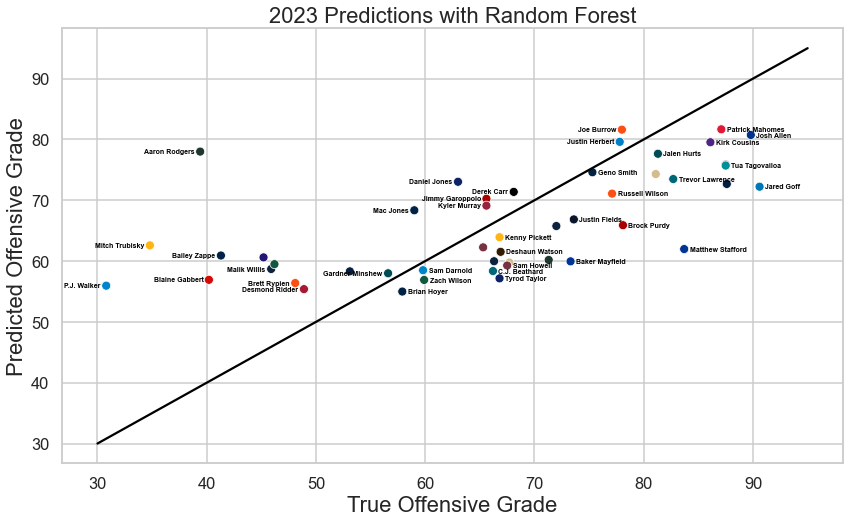

In [ ]:
# visualize predictions
plt.figure(figsize=(14, 8))

# lists for annotating player names
over_drops = ['Mike White', 'Cooper Rush', 'Tyler Huntley']
under_drops = ['Jameis Winston', 'Taylor Heinicke', 'Ryan Tannehill', 'Andy Dalton', 'Dak Prescott', 'Joshua Dobbs', 
               'Lamar Jackson', 'Jordan Love']

# title, labels
plt.title('2023 Predictions with Random Forest', fontsize=22)
plt.xlabel('True Offensive Grade', fontsize=22)
plt.ylabel('Predicted Offensive Grade', fontsize=22)

# team colors
color_palette = {color: color for color in preds_df['color'].unique()}

# plot players as points
sns.scatterplot(data=preds_df, x='y_true', y='y_pred', hue='color', palette=color_palette, legend=False)

# plot line to show perfect predictions
sns.lineplot(x=range(30,96), y=range(30,96), color='black')

# annotating each point with the player's name
for index, row in preds_df.iterrows():
    # over preds (above line)
    if (row['y_pred'] > row['y_true']) and (row['player'] not in over_drops):
        plt.text(row['y_true']-0.5, row['y_pred']-0.3, row['player'], horizontalalignment='right', color='black', 
             weight='semibold', fontsize=7)
    # under preds (below line)
    elif (row['y_pred'] < row['y_true']) and (row['player'] not in under_drops):
        plt.text(row['y_true']+0.5, row['y_pred']-0.3, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)

- Each point represents a single player in 2023. The distance from the black line is how far off our prediction was. Ideally, a perfect model would only have dots on the line. 
- Dots above the line are cases in which our model __overpredicted__ the player's performance, and dots below the line are __underpredictions__.
- You can see that the worst prediction, by far, is __Aaron Rodgers__, with an error of 38.6. It should be noted that he was injured on the 4th play of the 2023 season with a torn achilles, so this point is definitely an outlier.

In [17]:
# all 48 QBs
print(f'Normal - RMSE: {mean_squared_error(y_test, preds, squared=False)}')
print(f'Normal - R^2 : {r2_score(y_test, preds)}\n')

# dropping aaron rodgers
print(f'Dropping Aaron Rodgers - RMSE: {mean_squared_error(y_test[1:], preds[1:], squared=False)}')
print(f'Dropping Aaron Rodgers - R^2 : {r2_score(y_test[1:], preds[1:])}')

Normal - RMSE: 12.157436114762524
Normal - R^2 : 0.397691290884134

Dropping Aaron Rodgers - RMSE: 10.920073785075424
Dropping Aaron Rodgers - R^2 : 0.492223269173908


- If we drop this point, our RMSE goes from a __12.16 to a 10.92__, and R^2 leaps from a __0.4 to a 0.49__.

In [18]:
# percent of preds within 10 pts
percent = (preds_df[1:].error.abs() < 10).sum() / (len(preds_df) - 1)

print(f'Excluding Aaron Rodgers, {percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

Excluding Aaron Rodgers, 66.0% of our model's predictions are within 10 pts of the true value.
